In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

plt.rcParams['axes.facecolor'] = 'lightgray'
sns.set(style="darkgrid")
np.set_printoptions(precision=3)

In [2]:
def boxplot_all_methods(plt_handle, res_all, title='', names=[], color=[]):
    res_all_df = pd.DataFrame(res_all.T)
    res_all_df.columns = names
    res_all_df_melt = res_all_df.melt(var_name='methods', value_name='accuracy')
    res_all_mean = np.mean(res_all, axis=1)
    
#     plt_handle.set_title(title, fontsize=15)

    plt_handle.axhline(res_all_mean[2], ls='--', color='b')
    plt_handle.axhline(res_all_mean[1], ls='--', color='r')
    ax = sns.boxplot(x="methods", y="accuracy", data=res_all_df_melt, palette=color, ax=plt_handle)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-60, ha='left', fontsize=20)
    ax.tick_params(labelsize=20)
    ax.yaxis.grid(False) # Hide the horizontal gridlines
    ax.xaxis.grid(True) # Show the vertical gridlines
    ax.set_xlabel("methods")
    ax.set_ylabel("accuracy")
    
    ax.set_xlabel("")
    ax.set_ylabel("Accuracy (%)", fontsize=20)

In [3]:
# perturb = 'whitepatch2M'
# perturb = 'rotation2M'
perturb = 'rotation2Ma'
# perturb = 'translation2M'
M = 2
subset_prop = 0.2
lamL2 = 0.
lamL1 = 0.
lr = 1e-4
epochs=100

In [4]:
names_short = ["Original", "Tar", "Src[1]", 'DIP[1]', 'DIP[1]-MMD']

prefix_template = 'results_MNIST/report_v8_%s_M%d_subsetprop%s_%s_lamMatch%s_lamMatchMMD%s_epochs%d_seed%d'

In [5]:
repeats = 10
nb_ba = 3 # Original, Tar, Src[1]
results_src_ba = np.zeros((M-1, nb_ba, 2, repeats))
results_tar_ba = np.zeros((nb_ba, 2, repeats))
for seed in range(repeats):
    savefilename_prefix = prefix_template % (perturb,
                                     M, str(subset_prop), 'baseline', 1., 1., epochs, seed)
    res = np.load("%s.npy" %savefilename_prefix, allow_pickle=True)
    
    results_src_ba[:, :, :, seed] =res.item()['src']
    results_tar_ba[:, :, seed] = res.item()['tar']

In [6]:
lamMatches = [10.**(k) for k in (np.arange(10)-5)]

In [7]:
nb_dip = 3 # DIP DIPOracle DIP-MMD
results_src_dip = np.zeros((len(lamMatches), M-1, nb_dip, 2, repeats))
results_tar_dip = np.zeros((len(lamMatches), nb_dip, 2, repeats))
for i, lam in enumerate(lamMatches):
    for seed in range(repeats):
        savefilename_prefix = prefix_template % (perturb,
                                         M, str(subset_prop), 'DIP', lam, lam, epochs, seed)
        res = np.load("%s.npy" %savefilename_prefix, allow_pickle=True)

        results_src_dip[i, :, :, :, seed] =res.item()['src']
        results_tar_dip[i, :, :, seed] = res.item()['tar']

In [8]:
# choose lambda based on the source test performance
lam_index_dip = np.zeros(nb_dip, dtype=int)
for i in range(nb_dip):
    src_test_acc_all = results_src_dip[:, 0, i, 1, :].mean(axis=1)
    # choose the largest lambda such that the source performance does not drop too much (5%)
    lam_index = 0
    for k, src_test_acc in enumerate(src_test_acc_all):
        if src_test_acc > src_test_acc_all[0] * 0.95:
            lam_index = k
    lam_index_dip[i] = lam_index
    print(lam_index)

8
8
7


In [9]:
results_tar_plot = np.concatenate((results_tar_ba[:, 0, :],
                                   results_tar_dip[lam_index_dip[0], 0, 0, :].reshape(1, -1),
                                   results_tar_dip[lam_index_dip[2], 2, 0, :].reshape(1, -1)), axis=0)

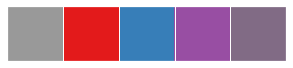

In [10]:
COLOR_PALETTE1 = sns.color_palette("Set1", 9, desat=1.)
COLOR_PALETTE2 = sns.color_palette("Set1", 9, desat=.7)
COLOR_PALETTE3 = sns.color_palette("Set1", 9, desat=.5)
COLOR_PALETTE4 = sns.color_palette("Set1", 9, desat=.3)
# COLOR_PALETTE2 = sns.color_palette("Dark2", 30)
# COLOR_PALETTE = COLOR_PALETTE1[:8] + COLOR_PALETTE2[:30]
COLOR_PALETTE = [COLOR_PALETTE1[8], COLOR_PALETTE1[0], COLOR_PALETTE1[1], COLOR_PALETTE1[3], COLOR_PALETTE4[3]]
sns.palplot(COLOR_PALETTE)


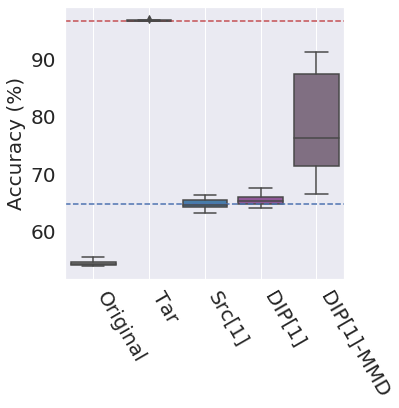

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))
boxplot_all_methods(axs, results_tar_plot*100,
                     title="MNIST: single source patch intervention", names=names_short,
                     color=np.array(COLOR_PALETTE)[:len(names_short)])

plt.savefig("paper_figures/%s" %"MNIST_%s_2M.pdf" %perturb, bbox_inches="tight")
plt.show()